# Differential ribosome distribution analysis. 

**Timing: 30 minutes**

This section will cover how to determine if the difference between our two datasets induces rate limiting pauses during translation elongation. First, the count arrays from the last section will be loaded into a Jupyter notebook and filtered so that only transcripts with sufficient length and read coverage are analyzed. Then, LOESS smoothing will be performed on the filtered count arrays and the cumulative distributions of the smoothed count arrays will be calculated. These cumulative distributions will be used to calculate the KS statistic for each gene. All of the genes will then be sorted into 3 separate bins based on whether they have low, medium, or high KS statistics. The fold enrichment of genes within each bin is then calculated. Finally, Fisher’s exact test will be used to determine if the observed enrichment of the target genes in various KS bins is statistically significant.

In [1]:
import sys
sys.path.append("../Python_scripts")

## Step 28
Load in all of the necessary Python packages:

In [2]:
import numpy as np
import pandas as pd
import utilities as utils
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from decimal import Decimal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from multiprocess import Pool

## Step 29
Load in the count arrays for both datasets:

In [3]:
# Load in the count arrays from the condition 1 dataset
condition1, names_1 = utils.load_count_positions("../Datasets/testing_count_arrays/condition1_1_counts.csv")

# Load in the count arrays from the condition 1 dataset
condition2, names_2 = utils.load_count_positions("../Datasets/testing_count_arrays/condition2_1_counts.csv")

## Step 30
Smooth out the count arrays using LOESS smoothing and calculate the cumulative read distributions. The get_smoothed_array function from the diff_utils.py file is set up to perform Loess smoothing with a window size equal to 5% of the transcript length and calculates the cumulative read distribution. This step can take some time, so it is recommended to use multiprocess’ Pool() function to complete this using multiple cores:

In [4]:
# Define the number of processers to use.
max_pool = 8

# Iterate through each dataset and calculate the smoothed density array
with Pool(max_pool) as p:
    pool_1, pool_2 = list(
            p.imap(utils.get_smoothed_array,
                   condition1)
        ), list(
            p.imap(utils.get_smoothed_array,
                    condition2)
        )

## Step 31
For each gene in both datasets, calculate the KS-statistic as the maximum distance between their smoothed cumulative distributions and then save this KS-statistic as a list:

In [5]:
# initialize 2 lists to hold the length and K-S statistic for each gene
ks_list = []
len_list = []

# iterate through each transcript in both datasets and calculate the length and K-S Statistic
for tr_1, tr_2, index in zip(condition1, condition2,
  list(range(len(condition1)))):
    smoothed_array_1, cumul_1 = pool_1[index]
    smoothed_array_2, cumul_2 = pool_2[index]
    ks = max(abs(cumul_1 - cumul_2))
    ks_list.append(ks)
    len_list.append(len(tr_1))

## Step 32
Combine the lists for the gene IDs, gene lengths, and K-S statistics into a pandas dataframe using the Pandas’ DataFrame function and rename the columns of the dataframe to something more suitable:

In [6]:
# Create a pandas dataframe of K-S statistics
ks_table = pd.DataFrame(list(zip(names_1, ks_list,
  len_list)))

# Rename the dataframe columns
ks_table.columns = ["gene_ID", "ks_stat", "gene_length"]

## Step 33
Load up a table containing a list of names for the genes affected by the differing conditions between our 2 datasets. the affected genes will be referred to as target genes or targets.

In [7]:
target_names = pd.read_csv("../Datasets/condition_targets/target_table.csv", names = ["gene_ID"])

## Step 34
Merge the table of K-S statistics and the table of target gene names into a new table using Pandas’ merge function. This new table will have an indicator column that shows if one of the target genes matched to one of the genes in the table of K-S statistics:

In [8]:
temp_df = pd.merge(ks_table, target_names, how = "left", on = "gene_ID", indicator = True)

## Step 35
Clean up the new table by removing any duplicates that may have been caused by multiple transcripts having the same gene name:

In [9]:
temp_df.drop_duplicates(subset ="gene_ID",keep = "first", inplace = True)

## Step 36
Use the indicator column created in step 34 to create 2 subsets of our table of KS statistics; one that only includes genes which matched with our target genes and one that only includes genes which did not match with our target genes:

In [10]:
# Filter the temporary dataframe to only include targets
targets = temp_df[temp_df._merge == "both"]

# Filter the temporary dataframe to only include non-targets
non_targets = temp_df[temp_df._merge == "left_only"]

## Step 37
Use matplotlib’s scatter and violinplot functions to create plots which visualize the KS statistic for all of the target and non-target genes (Figure 3A):

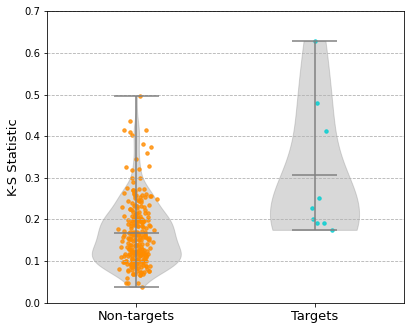

In [11]:
# Initialize axes objects
fig = figure(figsize = (5.5,4.5))
ax = fig.add_axes([0,0,.9,.9])

# Add violin plots
violin_parts = ax.violinplot([non_targets.ks_stat,targets.ks_stat], showmeans = True)

# Alter violin plot colours
for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
# Add dotplots
x = np.random.normal(1, 0.04, size=len(non_targets.ks_stat))
ax.scatter(x, non_targets.ks_stat, s = 12, color = "darkorange", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(targets.ks_stat))
ax.scatter(x, targets.ks_stat, s = 12,  color = "darkturquoise", alpha=0.8)

# Determine x and y axis limits
ax.set_xlim(0.5,2.5)
ax.set_ylim(0,0.7)

# Label the axes.
positions = (1,2)
labels = ("Non-targets", "Targets")
ax.set_xticks(positions, labels, fontsize = 13)
plt.ylabel("K-S Statistic", fontsize = 13)

# Create grid lines
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")

## Step 38
Divide the data into low, medium, and high K-S fractions and determine the fold enrichment of the target genes in each fraction using the determine_enrichment function from utilities.py. The K-S fractions in this example are set as genes with a K-S statistic less than 0.15, genes with a K-S statistic between 0.15 and 0.3, and genes with a K-S statistic above 0.3:

In [12]:
# Define the cut-off for the high K-S fraction and the number of fractions to create. 
upper_ks = 0.3
N_cats = 2
enrich, sections = utils.determine_enrichment(targets, non_targets, upper_ks, N_cats)

## Step 39
Perform Fisher’s exact test to determine if the enrichment of targets in any of the K-S fractions is significant. The Fisher_exact_p_values function from utilities.py can be used to automatically calculate these P-values for each of the KS fractions. This function automatically performs three tests, so the outputted P-values should be adjusted using the Benjamini Hochberg method. This can be done using statsmodels’ multipletests function:

In [13]:
# Perform Fisher’s exact for all three fractions simultaneously. 
p_values = utils.Fisher_exact_p_values(targets, non_targets, sections)

# Adjust the P-values using the Benjamini Hochberg method
adj_p_values = multipletests(p_values, method = "fdr_bh")[1]

## Step 40
Use matplotlib’s pyplot.bar function to create a series of barplots that show the fold enrichment of genes that are targets in each fraction (Figure 3A):

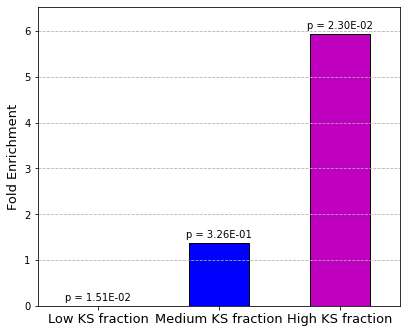

In [14]:
# Specify the figure size. 
figure(figsize = (6.5,5.5))

# Create a barplot showing enrichment in each fraction.
bps = plt.bar([1,2,3],enrich, width = 0.5,
  tick_label = ["Low KS fraction","Medium KS fraction",
  "High KS fraction"], color = ["g", "b", "m"], edgecolor =
  "black")

# Adjust fontsize and labels. 
plt.xticks(fontsize = 13)
plt.ylabel("Fold Enrichment", fontsize = 13)

# Increase plot margins
plt.margins(0.1,0.1)

# Create grid lines
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")

# Write the adjusted p-values on top of each bar. 
for b, p in zip(bps, adj_p_values):
    height = b.get_height()
    plt.annotate("p = " + "{}".format("%.2E" % Decimal(p)),
      xy=(b.get_x() + b.get_width() / 2, height),
      xytext=(0, 3), textcoords="offset points",
      ha="center", va="bottom")

**Optional:** After completing the analysis, the following optional steps can be used to create graphs showing the count arrays and smoothed cumulative read distributions for individual genes of interest in order to observe the changes in read distribution. To recreate the plots seen in Figure 4 or Figure 5 using the testing data, “gene_of_interest” should be replaced with “Selenop” or “Aox3” respectively. 


## Step 41 
Choose a gene of interest and then find its count array for both the condition 1 and condition 2 datasets:

In [15]:
# Select gene of interest
goi = "Selenop"

# Initialize lists to hold the count arrays. 
goi_array_cond1 = []
goi_array_cond2 = []

# Iterate through the condition 1 and condition 2 datasets and extract count arrays from the gene of interest. 
for tr_1, tr_2, name in zip(condition1, condition2,
  names_1):
    if name == goi:
        goi_array_cond1 = tr_1
        goi_array_cond2 = tr_2
if len(goi_array_cond1) == 0:
    raise ValueError("Gene name not found")

## Step 42 
Choose a gene of interest and then find its count array for both the condition 1 and condition 2 datasets:

In [16]:
# Smoothed array from condition 1 dataset
smoothed_array_1, cumul_1 = utils.get_smoothed_array(goi_array_cond1 + 0.00000000001)

# Smoothed array from condition 2 dataset
smoothed_array_2, cumul_2 = utils.get_smoothed_array(goi_array_cond2 + 0.00000000001)

## Step 43
Use Matplotlib's bar function to create bar plots that show the raw count arrays for the gene of interest:

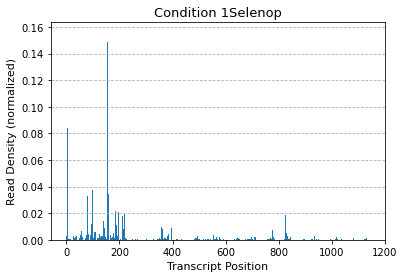

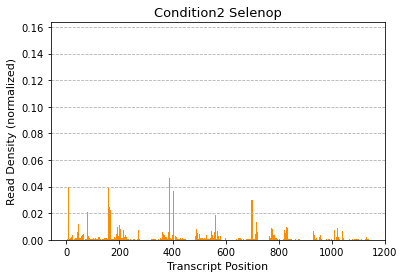

In [17]:
# Find the maximum read density between both arrays so it can be used to define the y-axis range. 
maxi = max([max(goi_array_cond1/sum(goi_array_cond1)),
  max(goi_array_cond2/sum(goi_array_cond2))])

# Create the bar plot for the condition 1 count array.
plt.bar(list(range(len(goi_array_cond1))),
  goi_array_cond1/sum(goi_array_cond1), width = 4)

# Define the y-axis range
plt.ylim([0,maxi*1.1])

# Add the axis labels and title 
plt.ylabel("Read Density (normalized)", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Condition 1" + goi, fontsize = 13)

# Create grid lines
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")

# Display plot
plt.show()

# Create the bar plot for the condition 1 count array.
plt.bar(list(range(len(goi_array_cond1))),
  goi_array_cond2/sum(goi_array_cond2), color = "darkorange",
  width = 4)

# Define the y-axis range
plt.ylim([0,maxi*1.1])

# Add the axis labels and title 
plt.ylabel("Read Density (normalized)", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Condition2 " + goi, fontsize = 13)

# Create grid lines
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")

## Step 44
Use Matplotlib's basic plot function to create line graphs that show the smoothed count arrays and the cumulative smoothed count arrays for the gene of interest:

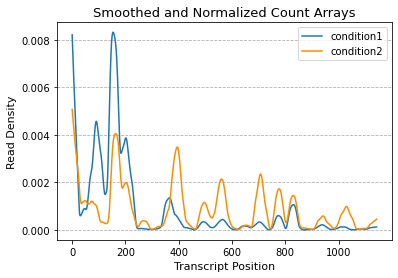

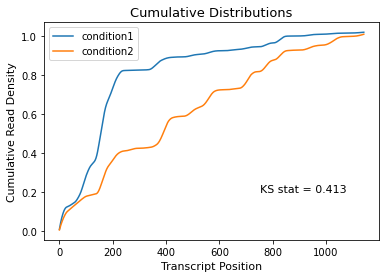

In [18]:
# Plot the smoothed count arrays from both datasets
plt.plot(smoothed_array_1, label = "condition1")
plt.plot(smoothed_array_2, label = "condition2", color =
  "darkorange")

# Add the axis labels, title, and legend
plt.ylabel("Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Smoothed and Normalized Count Arrays", fontsize =
  13)
plt.legend()

# Create grid lines
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")

# Display plot
plt.show()

# Calculate the K-S statistic from the cumulative distributions.
ks = max(abs(cumul_1 - cumul_2))

# Plot the smoothed count arrays from both datasets
plt.plot(cumul_1, label = "condition1")
plt.plot(cumul_2, label = "condition2")

# Write the K-S statistic on the plot
plt.text(len(cumul_2)*0.66, 0.2, "KS stat = " +
  str(round(ks,3)), fontsize = 11)

# Add the axis labels, title, and legend
plt.ylabel("Cumulative Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Cumulative Distributions", fontsize = 13)
plt.legend()

# Create gridlines
axes = plt.gca()